In [143]:
import matplotlib.pyplot as plt

import numpy as np
from skimage import io
from skimage.transform import AffineTransform
from skimage.measure import ransac
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import match_descriptors, plot_matches, SIFT
from matplotlib.patches import ConnectionPatch
from skimage import measure
from skimage.transform import resize, ProjectiveTransform, SimilarityTransform, warp
from skimage import measure
import random


#print numpy array without scientific notation
np.set_printoptions(suppress=True)

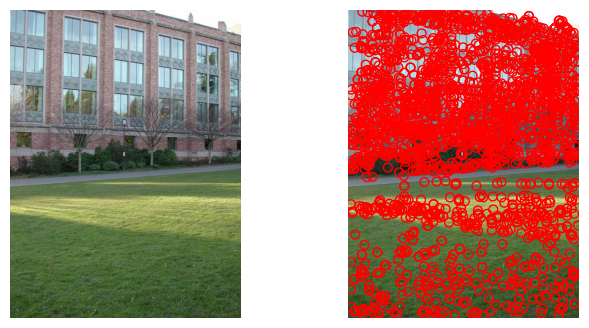

In [144]:
img1 = io.imread('data/campus_000.jpg')

# Extract keypoints from image using SIFT
img1_gray = rgb2gray(img1)
sift = SIFT()
sift.detect_and_extract(img1_gray)
keypoints1 = sift.keypoints
descriptors1 = sift.descriptors

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].imshow(img1)
ax[1].axis('off')
ax[1].scatter(keypoints1[:, 1], keypoints1[:, 0], facecolor='none', edgecolor='r', s=40)
plt.show()
    

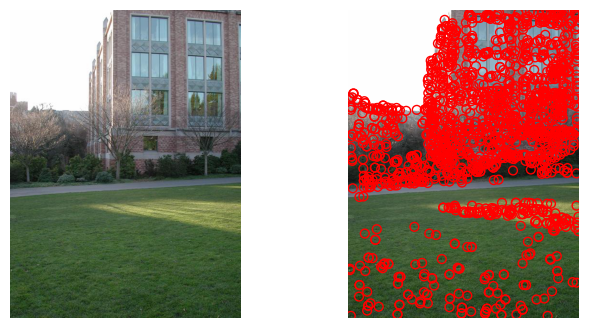

In [145]:
img2 = io.imread('data/campus_001.jpg')

# Extract keypoints from image using SIFT
img2_gray = rgb2gray(img2)
sift.detect_and_extract(img2_gray)
keypoints2 = sift.keypoints
descriptors2 = sift.descriptors

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(img2)
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].scatter(keypoints2[:, 1], keypoints2[:, 0], facecolor='none', edgecolor='r', s=40)
plt.show()

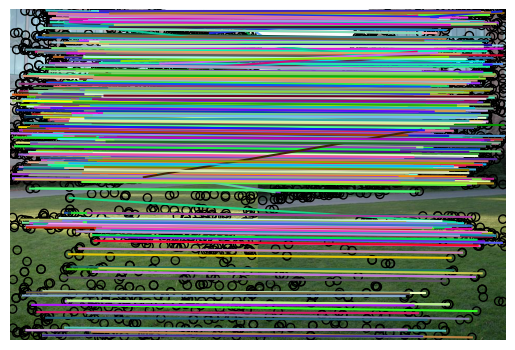

In [146]:
# Match descriptors between img1 and img2
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True, max_ratio=0.8)

# Display matches
fig, ax = plt.subplots()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
plt.show()

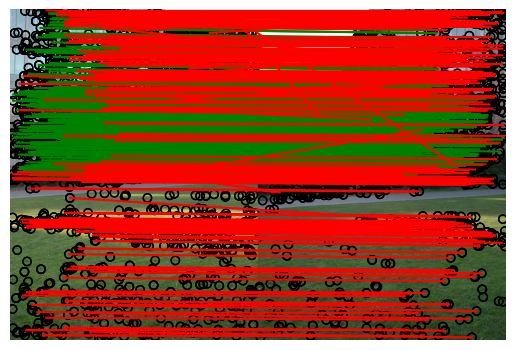

In [147]:
model12, inliers12 = ransac((keypoints1[matches12[:, 0]][:, ::-1], keypoints2[matches12[:, 1]][:, ::-1]),  # source and destination coordinates
                            AffineTransform,  # the model class
                            min_samples=3,  # minimum number of coordinates to fit the model
                            residual_threshold=2,  # maximum distance for a data point to be considered an inlier
                            max_trials=100)  # maximum number of iterations
outliers12 = inliers12 == False

# Display inlier and outlier matches
fig, ax = plt.subplots()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12[inliers12], matches_color='g')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12[outliers12], matches_color='r')
ax.axis('off')
plt.show()

In [159]:
# Select the points in img1 that match with img2 and vice versa
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)
destination = keypoints1[matches[:, 0]]
source = keypoints2[matches[:, 1]]
print(source)
#print(np.array(matches))

[[ 23 435]
 [  3 443]
 [  4 384]
 ...
 [118 315]
 [116 348]
 [124 386]]


In [149]:
# note that kp1 is the keypoint from the source image
# and kp2 is their coresponding match point
def compute_affine_transform(kp1, kp2):
    ones = np.ones((kp1.shape[0], 1))
    kp1 = np.concatenate((kp1, ones), axis=1)
    A = np.zeros((2*kp1.shape[0], 6))
    for i in range(0,len(A),2):
        A[i] = np.concatenate((kp1[i//2], np.array([0,0,0])))
        A[i+1] = np.concatenate((np.array([0,0,0]), kp1[i//2]))
    
    b = np.reshape(kp2, -1)
    x = ((np.linalg.inv(((A.T).dot(A)))).dot(A.T)).dot(b)
    x = np.concatenate((x, [0,0,1]))
    x = np.reshape(x, (3,3))
    return x
    
affine_matrix = compute_affine_transform(source, destination)
print(affine_matrix)
#print(affine_matrix.dot([1,8,1]))

[[  0.79254919  -0.05276895  63.61776809]
 [ -0.01576004  -0.34220428 284.05433112]
 [  0.           0.           1.        ]]


In [150]:
def compute_projective_transform(kp1, kp2):
    # Convert points to homogeneous coordinates
    kp1 = np.hstack([np.array(kp1), np.ones((len(kp1), 1))])
    
    # Solve for the projective transform matrix (homography) using linear least squares
    A = []
    for i in range(len(kp1)):
        x, y, z = kp1[i]
        u, v    = kp2[i]
        A.append([x, y, 1, 0, 0, 0, -x*u, -y*u])
        A.append([0, 0, 0, x, y, 1, -x*v, -y*v])
    A = np.array(A)
    b = np.reshape(kp2, -1)
    x = ((np.linalg.inv(((A.T).dot(A)))).dot(A.T)).dot(b)
    x = np.concatenate((x, [1]))
    x = np.reshape(x, (3,3))
    return x
projective_matrix = compute_projective_transform(source, destination)
print(projective_matrix)

[[ -0.357592    -0.70952207 313.15813151]
 [ -0.18766137  -0.5712202  241.69468843]
 [ -0.00101867  -0.00227269   1.        ]]


In [151]:
#this code is from chatGPT
def get_projective_transform_matrix(src_points, dst_points):
    """
    Computes the projective transform matrix (homography) between two sets of points.
    
    Args:
        src_points (list of tuples): source points in the original image
        dst_points (list of tuples): destination points in the transformed image
    
    Returns:
        H (numpy array): the 3x3 projective transform matrix
    """
    # Convert points to homogeneous coordinates
    src_points = np.hstack([np.array(src_points), np.ones((len(src_points), 1))])
    dst_points = np.hstack([np.array(dst_points), np.ones((len(dst_points), 1))])
    
    # Solve for the projective transform matrix (homography) using linear least squares
    A = []
    for i in range(len(src_points)):
        x, y, z = src_points[i]
        u, v, w = dst_points[i]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.array(A)
    
    U, s, V = np.linalg.svd(A)
    H = V[-1,:].reshape((3, 3))
    H /= H[2,2]
    
    return H
projective_matrix_test = compute_projective_transform(source, destination)
print(projective_matrix_test)

[[ -0.357592    -0.70952207 313.15813151]
 [ -0.18766137  -0.5712202  241.69468843]
 [ -0.00101867  -0.00227269   1.        ]]


In [152]:
def ransac(source_kp, dest_kp, max_iteration, min_samples, thresh, matrix_type):
    best_inliers = []
    best_score = 0
    
    for i in range(max_iteration):
        # Select a random subset of keypoints
        sample_indices = random.sample(range(len(source_kp)), min_samples)
        source_sample = [source_kp[idx] for idx in sample_indices]
        dest_sample = [dest_kp[idx] for idx in sample_indices]
        source_sample = np.array(source_sample)
        
        # Compute the transformation matrix using the sample
        if matrix_type == "affine":
            H = compute_affine_transform(source_sample, dest_sample)
        else:
            H = compute_projective_transform(source_sample, dest_sample)
        
        # Apply the transformation to the source keypoints
        # transformed_pts aka predicted distination keypoints
        transformed_pts = apply_transform_matrix(source_kp, H)
        
        # Count the number of inliers (i.e., keypoints with distances less than the threshold)
        inliers = []
        for j in range(len(dest_kp)):
            if np.linalg.norm(transformed_pts[j] - dest_kp[j]) < thresh:
                inliers.append(j)
        score = len(inliers)
        
        if score > best_score:
            # Update the best model if we found a better one
            best_score = score
            best_inliers = inliers
            
    return best_inliers

def apply_transform_matrix(points, H):
    """Apply transform matrix to a set of 2D points"""
    points = np.array(points)
    ones = np.ones((points.shape[0], 1))
    points = np.hstack([points, ones])

    transformed_pts = []
    for point in points:
        #it is possible to get a negative value overhere, remember this is feature point of different images
        transformed_point = H.dot(point)
        transformed_pts.append(transformed_point[0:2])
    return np.array(transformed_pts)

best_matching_kp_idx = ransac(source, destination, 300, 4, 1.5, "affine")
# print(source.shape)
# print(best_matching_kp_idx)
print(len(best_matching_kp_idx))

231


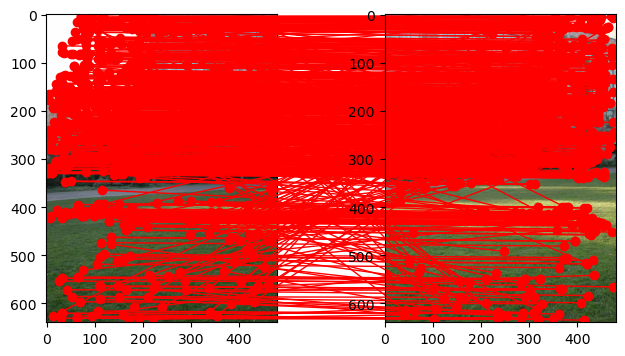

In [153]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(img2, cmap='gray')
ax2.imshow(img1, cmap='gray')

for i in range(source.shape[0]):
    coordB = [destination[i, 1], destination[i, 0]]
    coordA = [source[i, 1], source[i, 0]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst[i, 1], dst[i, 0], 'ro')
    ax2.plot(src[i, 1], src[i, 0], 'ro')

In [160]:
sk_M, sk_best = measure.ransac((source[:, ::-1], destination[:, ::-1]), ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=300)
print(sk_M)

<ProjectiveTransform(matrix=
    [[   1.11232293,   -0.00891858, -290.47950731],
     [   0.08520445,    1.09312701,  -38.89964251],
     [   0.00023071,    0.00002344,    1.        ]])>


175


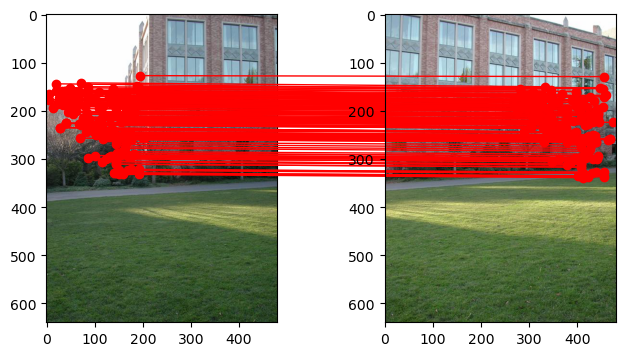

In [161]:
print(np.count_nonzero(sk_best))
src_best = keypoints2[matches[sk_best, 1]][:, ::-1]
dst_best = keypoints1[matches[sk_best, 0]][:, ::-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(img2)
ax2.imshow(img1)

for i in range(src_best.shape[0]):
    coordB = [dst_best[i, 0], dst_best[i, 1]]
    coordA = [src_best[i, 0], src_best[i, 1]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst_best[i, 0], dst_best[i, 1], 'ro')
    ax2.plot(src_best[i, 0], src_best[i, 1], 'ro')

(231, 2)
(231, 2)


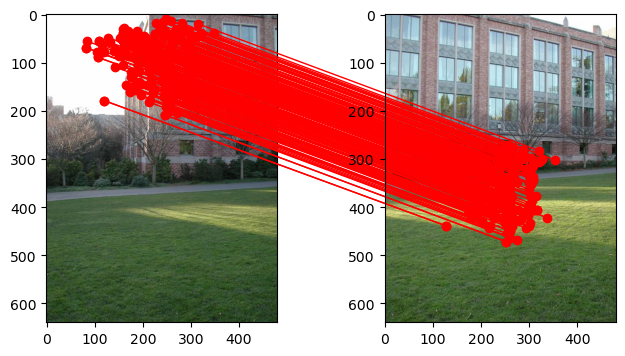

In [157]:
def plot_matching_ransac(img1, img2, source_kp, dest_kp, matching_list):
    source_best = np.array([source_kp[i] for i in matching_list])
    dest_best = np.array([dest_kp[i] for i in matching_list])
#     print(source_best.shape)
#     print(dest_best.shape)
    
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(img2)
    ax2.imshow(img1)

    for i in range(source_best.shape[0]):
        coordB = [dest_best[i, 0], dest_best[i, 1]]
        coordA = [source_best[i, 0], source_best[i, 1]]
        con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                              axesA=ax2, axesB=ax1, color="red")
        ax2.add_artist(con)
        ax1.plot(dest_best[i, 0], dest_best[i, 1], 'ro')
        ax2.plot(source_best[i, 0], source_best[i, 1], 'ro')

plot_matching_ransac(img1, img2, source, destination, best_matching_kp_idx)